Loading the VGG16 network with pretrained weights

In [2]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 75s 0us/step


Preprocessing an input image for VGG16

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [5]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 5us/step
Predicted: [('n02504458', 'African_elephant', 0.5789891), ('n01871265', 'tusker', 0.39689228), ('n02504013', 'Indian_elephant', 0.02410801)]


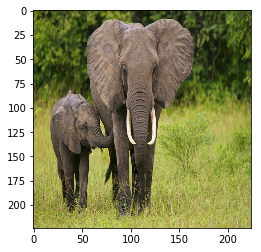

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [9]:
preds.shape

(1, 1000)

In [10]:
np.argmax(preds[0])

386

Setting up the Grad-CAM algorithm

In [12]:
from keras import backend as K

african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heapmap = np.mean(conv_layer_output_value, axis=-1)

Heatmap post-processing

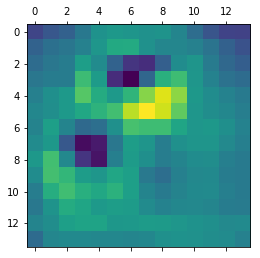

In [13]:
heatmap = np.maximum(heapmap, 0)
heapmap /= np.max(heatmap)
plt.matshow(heapmap)

Superimposing the heatmap with the original picture

In [22]:
# pip3 install opencv-python
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

superimposed_img = superimposed_img.astype('uint8')

cv2.imwrite(img_path, superimposed_img)

True

In [23]:
superimposed_img.dtype

dtype('uint8')

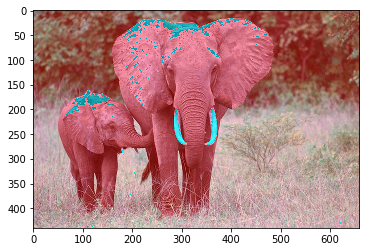

In [24]:
plt.imshow(superimposed_img)
plt.show()